Usecase test 3: Can links be found relating to predispositions for ASD co-morbidities?

1. Take count of genes cited in the data across all articles highlighting the most cited overall (by most connections)

In [1]:
import rdflib

filename = "cleaned_maingraph.nt"
g = rdflib.Graph()
g.parse(filename, format="nt")

<Graph identifier=Nfb2ccab163924c9bb22657774c4b48dd (<class 'rdflib.graph.Graph'>)>

In [5]:
#retriving count of genes featuring in the greatest number of distinct papers  

count_query = """
    PREFIX EDAM: <http://edamontology.org/>
    PREFIX RDF: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX DCT: <http://purl.org/dc/terms/>
    PREFIX BIOLINK: <https://w3id.org/biolink/vocab/>
    PREFIX ENSEMBL: <http://identifiers.org/ensembl/>
    PREFIX NCBIGENE: <http://identifiers.org/ncbigene/>
    PREFIX XSD: <http://www.w3.org/2001/XMLSchema#>

    SELECT ?gene (COUNT(DISTINCT ?root_subject) AS ?count)
    WHERE {
        ?root_subject ?p ?o
        FILTER(STRSTARTS(STR(?root_subject), "https://pubmed.ncbi.nlm.nih.gov/"))
        ?root_subject ?p1 ?intermediate1 .
        ?intermediate1 ?p2 ?intermediate2 .
        ?intermediate2 BIOLINK:Gene ?gene .
        ?intermediate2 EDAM:data_1669 ?pvalue .
        FILTER(DATATYPE(?pvalue) = XSD:double && ?pvalue < 0.05) .
        ?intermediate2 EDAM:data_3754 ?logvalue .
        FILTER(DATATYPE(?logvalue) = XSD:double && (?logvalue > 0.5 || ?logvalue < -0.5))
    }
    GROUP BY ?gene
    ORDER BY DESC(?count)
    LIMIT 50
"""
results = g.query(count_query)
print("Gene | Count")
print("-----|------")
for row in results:
    gene = str(row['gene'])
    count = int(row['count'].toPython()) 
    print(f"{gene} | {count}")

Gene | Count
-----|------
https://monarchinitiative.org/HGNC:20693 | 7
https://monarchinitiative.org/HGNC:5246 | 7
https://monarchinitiative.org/HGNC:7784 | 6
https://monarchinitiative.org/HGNC:3432 | 6
https://monarchinitiative.org/HGNC:21386 | 6
https://monarchinitiative.org/HGNC:11867 | 6
https://monarchinitiative.org/HGNC:4571 | 6
https://monarchinitiative.org/HGNC:6824 | 6
https://monarchinitiative.org/HGNC:4579 | 6
https://monarchinitiative.org/HGNC:8008 | 6
https://monarchinitiative.org/HGNC:19311 | 6
https://monarchinitiative.org/HGNC:20990 | 6
https://monarchinitiative.org/HGNC:17302 | 6
https://monarchinitiative.org/HGNC:2475 | 6
https://monarchinitiative.org/HGNC:10941 | 6
https://monarchinitiative.org/HGNC:7406 | 6
https://monarchinitiative.org/HGNC:1784 | 6
https://monarchinitiative.org/HGNC:3999 | 6
https://monarchinitiative.org/HGNC:7954 | 5
https://monarchinitiative.org/HGNC:16844 | 5
https://monarchinitiative.org/HGNC:10940 | 5
https://monarchinitiative.org/HGNC:20823 

In [6]:
#writing output to file:
#with open("output1.txt", "w") as file:
#    for row in results:
#        gene = str(row['gene'])
#        count = int(row['count'].toPython()) 
#        file.write(f"{gene} | {count}\n")

2. Query external Monarch Initiative graph using API using these top-cited genes for related phenotypes 

In [7]:
top_genes = []
for row in results:
    top_genes.append(str(row['gene']))
print(top_genes)

['https://monarchinitiative.org/HGNC:20693', 'https://monarchinitiative.org/HGNC:5246', 'https://monarchinitiative.org/HGNC:7784', 'https://monarchinitiative.org/HGNC:3432', 'https://monarchinitiative.org/HGNC:21386', 'https://monarchinitiative.org/HGNC:11867', 'https://monarchinitiative.org/HGNC:4571', 'https://monarchinitiative.org/HGNC:6824', 'https://monarchinitiative.org/HGNC:4579', 'https://monarchinitiative.org/HGNC:8008', 'https://monarchinitiative.org/HGNC:19311', 'https://monarchinitiative.org/HGNC:20990', 'https://monarchinitiative.org/HGNC:17302', 'https://monarchinitiative.org/HGNC:2475', 'https://monarchinitiative.org/HGNC:10941', 'https://monarchinitiative.org/HGNC:7406', 'https://monarchinitiative.org/HGNC:1784', 'https://monarchinitiative.org/HGNC:3999', 'https://monarchinitiative.org/HGNC:7954', 'https://monarchinitiative.org/HGNC:16844', 'https://monarchinitiative.org/HGNC:10940', 'https://monarchinitiative.org/HGNC:20823', 'https://monarchinitiative.org/HGNC:22195',

In [8]:
import requests
import pandas as pd
from collections import defaultdict

hgnc_ids = [gene.split('/')[-1] for gene in top_genes]
#getting all associations from monarch api
def get_associations(gene_id, association_type):
    api_url = "https://api-v3.monarchinitiative.org/v3/api/association"
    params = {
        "subject": gene_id,
        "predicate": association_type,
        "offset": 0,
        "limit": 100
    }
    try:
        response = requests.get(api_url, params=params)
        response.raise_for_status()
        data = response.json()
        return data.get('items', [])
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return []

def get_gene_info(gene_id):
    
    #using predicates to return relevant associations
    phenotypes = get_associations(gene_id, "biolink:has_phenotype")
    diseases = get_associations(gene_id, "biolink:gene_associated_with_condition")
    processes = get_associations(gene_id, "biolink:participates_in")
    functions = get_associations(gene_id, "biolink:enables")
    
    return {
        'Phenotypes': [item.get('object_label', 'Unknown') for item in phenotypes],
        'Diseases': [item.get('object_label', 'Unknown') for item in diseases],
        'Biological Processes': [item.get('object_label', 'Unknown') for item in processes],
        'Molecular Functions': [item.get('object_label', 'Unknown') for item in functions]
    }

results = {}
for gene in hgnc_ids:
    results[gene] = get_gene_info(gene)


In [9]:

# Create a summary of shared associations between the given genes (using set to remove duplicates)
shared_associations = defaultdict(lambda: defaultdict(set))
for category in ['Phenotypes', 'Diseases', 'Biological Processes', 'Molecular Functions']:
    all_items = set()
    for gene, data in results.items():
        all_items.update(data.get(category, []))
    
    for item in all_items:
        genes_with_item = set(gene for gene, data in results.items() if item in data.get(category, []))
        if len(genes_with_item) > 1:
            shared_associations[category][item] = genes_with_item

for category, items in shared_associations.items():
    print(f"\n{category}:")
    if items:
        df = pd.DataFrame([(item, ', '.join(sorted(genes))) for item, genes in items.items()], 
                          columns=[category, 'Genes'])
        print(df.to_string(index=False))
    else:
        print("No shared associations found.")

# Print unique associations for each gene
print("\nUnique associations for each gene:")
for gene, data in results.items():
    print(f"\n{gene}:")
    for category, items in data.items():
        unique_items = set(item for item in items if len(shared_associations[category].get(item, [])) <= 1)
        if unique_items:
            print(f"  {category}:")
            for item in sorted(unique_items):
                print(f"    - {item}")
                


Phenotypes:
                                                   Phenotypes                                                                                                                                                                                           Genes
                                            Sleep disturbance                                                                                                                                                                HGNC:21637, HGNC:3432, HGNC:4571
                                                  Adult onset                                                                                                                                                                            HGNC:3999, HGNC:5246
                                                    Scoliosis                                                                                                                                                    HGNC:1077, HGNC:

In [10]:
# saving results output to file if needed:
# #with open("output2.txt", "w") as file:
#    file.write(str(results))

In [ ]:
#using the results dictionary to create heat maps for the most prevelant phenotypes and molecular functions

from matplotlib.lines import lineStyles
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
import textwrap


phenotypes = set()
for category_dict in results.values():
    phenotypes.update(category_dict['Phenotypes'])

# Create a DataFrame where each row represents the presence of a phenotype for a gene
data = []
for gene, category_dict in results.items():
    row = {phenotype: 1 if phenotype in category_dict['Phenotypes'] else 0 for phenotype in phenotypes}
    data.append(row)

df = pd.DataFrame(data, index=results.keys())

phenotype_counts = df.sum(axis=0)
top_phenotypes = phenotype_counts.nlargest(15).index
df_top = df[top_phenotypes]

cmap = mcolors.ListedColormap(['white', 'navy'])
wrapped_labels = [textwrap.fill(label, width=20) for label in top_phenotypes]

plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    df_top,
    cmap=cmap,
    cbar=False,  
    linewidths=0.1, 
    linecolor='lightgrey',  
    annot=False  
)

ax.set_xticklabels(wrapped_labels, rotation=90)
ax.set_yticks(np.arange(len(df_top.index)) + 0.5)
ax.set_yticklabels(df_top.index)
ax.set_xlabel('Top 15 Phenotypes')
ax.set_ylabel('Genes')
plt.tight_layout()

#plt.savefig('heatmap_top_15_phenotypesv2.png', format='png', dpi=300)
plt.show()

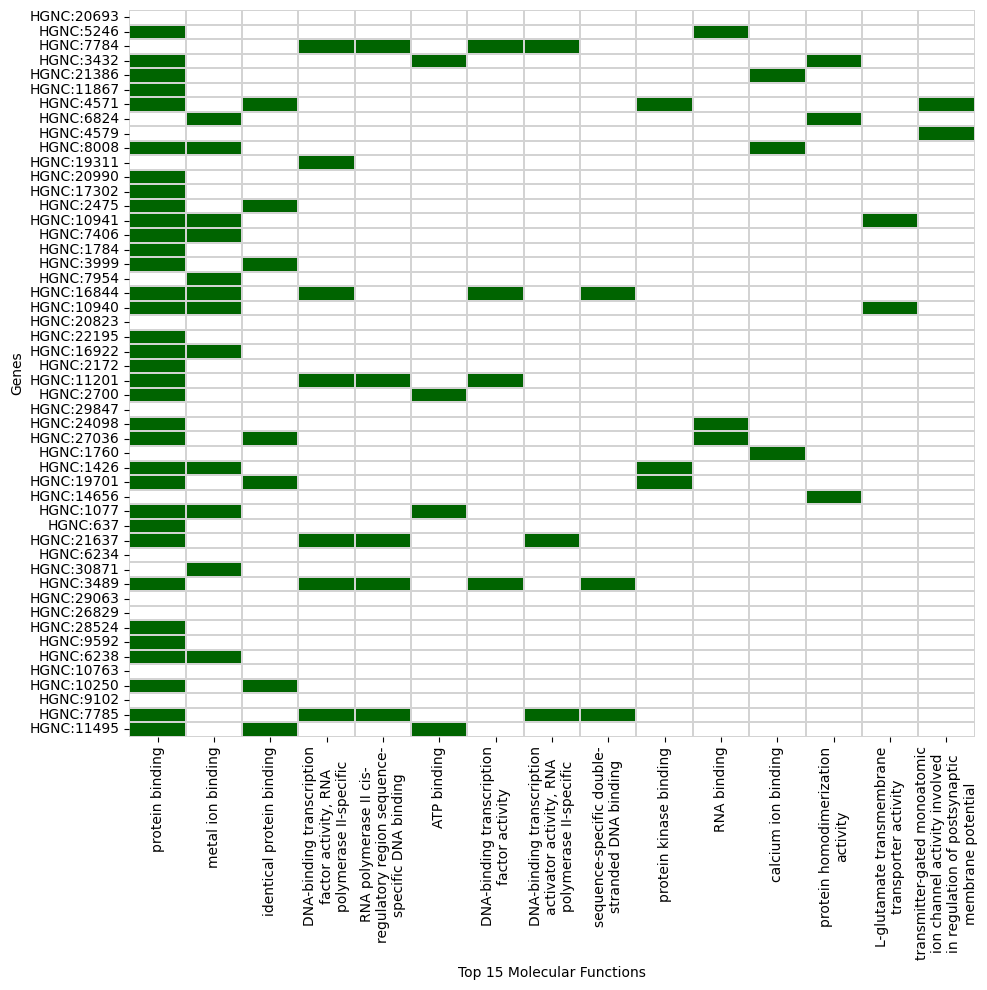

In [5]:
molecular_functions = set()
for category_dict in results.values():
    molecular_functions.update(category_dict['Molecular Functions'])

# Create a DataFrame where each row represents the presence of a molecular function for a gene
data2 = []
for gene, category_dict in results.items():
    row = {mf: 1 if mf in category_dict['Molecular Functions'] else 0 for mf in molecular_functions}
    data2.append(row)

# Create a DataFrame from the data
df2 = pd.DataFrame(data2, index=results.keys())

# Compute the frequency of each molecular function
mf_counts = df2.sum(axis=0)

# Get the top 15 molecular functions by frequency
top_molecular_functions = mf_counts.nlargest(15).index

# Filter the DataFrame to include only the top molecular functions
df_top_mf = df2[top_molecular_functions]

cmap = mcolors.ListedColormap(['white', 'darkgreen'])
wrapped_labels = [textwrap.fill(label, width=30) for label in top_molecular_functions]

# Create the heatmap
plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    df_top_mf,
    cmap=cmap,
    cbar=False,  
    linewidths=0.1, 
    linecolor='lightgrey',  
    annot=False  
)

ax.set_xticklabels(wrapped_labels, rotation=90)
ax.set_yticks(np.arange(len(df_top_mf.index)) + 0.5)
ax.set_yticklabels(df_top_mf.index)
ax.set_xlabel('Top 15 Molecular Functions')
ax.set_ylabel('Genes')

plt.tight_layout()

#plt.savefig('heatmap_top_15_molfuncv2.png', format='png', dpi=300)
plt.show()